## Topic 1 FGSM & PGD Attacks

Both Fast Gradient Sign Method (FGSM) and Projected Gradient Descent (PGD) are adversarial attack methods used to test the robustness of machine learning models, particularly those used in image classification. They work by subtly perturbing input data (like images) in a way that causes the model to misclassify it with high confidence – even though the change is often imperceptible to humans.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import copy
import time
import os
from tqdm.notebook import tqdm
from huggingface_hub import hf_hub_download

weights_path = hf_hub_download(repo_id="AAAAAA2121/weight_host", filename="resnet18-cifar100.pt")
print(f"Weights downloaded to: {weights_path}")


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define transformations
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

# Load datasets
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

resnet18-cifar100.pt:   0%|          | 0.00/45.0M [00:00<?, ?B/s]

Weights downloaded to: /root/.cache/huggingface/hub/models--AAAAAA2121--weight_host/snapshots/b9f20fa3b0bffee8eca8e6756717ac2abfc8a048/resnet18-cifar100.pt
Using device: cpu


### 2. Load the model

In [ ]:
resnet18 = torch.load(weights_path, weights_only=False) #Use model like one that we trained earlier (map_location=torch.device('cpu') if you run out of T4)


### 1.3 Attack Defining
1. Fast Gradient Sign Method (FGSM)

Concept: FGSM is a single-step adversarial attack. It calculates the gradient of the loss function with respect to the input image and then adds a small perturbation in the direction of the sign of that gradient. Essentially, it finds the direction in which a tiny change to the input will most quickly increase the loss (making the model more wrong).

How it works:

Calculate Gradient: Given an input image x, a target label y (the true label), and a machine learning model f, calculate the gradient of the loss function J(f(x), y) with respect to the input image x: ∇<sub>x</sub> J(f(x), y). This gradient tells you how much each pixel value affects the error of the prediction.
Get the Sign: Take the sign of the gradient: sign(∇<sub>x</sub> J(f(x), y)). This results in a matrix of +1s and -1s indicating the direction to change each pixel to maximize the loss.
Apply Perturbation: Add a small multiple (epsilon - denoted as ε) of the sign of the gradient to the original image: x' = x + ε * sign(∇<sub>x</sub> J(f(x), y)) . x' is the adversarial example.
Clip (Optional but Recommended): Often, the perturbed image x' will have pixel values outside the valid range (e.g., 0-255 for images, or 0-1 normalised). Clipping ensures pixel values stay within this range: x' = clip(x', 0, 1)
Epsilon (ε): This is a crucial parameter controlling the magnitude of the perturbation. A smaller epsilon means a less noticeable change to the image, but might not be enough to fool the model. A larger epsilon makes the attack more effective but also more detectable.

Strengths: Simple and fast to compute.
Weaknesses: Relatively weak compared to other attacks like PGD. Often easily defended against.


2. Projected Gradient Descent (PGD)

Concept: PGD is an iterative version of FGSM. Instead of taking just one step in the direction of the gradient, it takes multiple small steps, projecting the adversarial example back into a valid region after each step. It can be thought of as repeatedly applying FGSM with a constrained step size.

How it works:

Initialization: Start with the original input image x.
Iterate: For a specified number of iterations (T):

1. Calculate Gradient: Calculate the gradient of the loss function with respect to the input image: ∇<sub>x</sub> J(f(x), y).

2. Update Adversarial Example: Update the adversarial example by adding a small step in the direction of the gradient: x' = x + α * sign(∇<sub>x</sub> J(f(x), y)) (where α is the step size - analogous to epsilon in FGSM but per iteration).

3. Projection: Project the updated adversarial example x' back onto a valid region around the original image x. This ensures the perturbation remains within a defined bound (often using an L-infinity norm constraint, meaning the maximum change for any single pixel is limited). The projection formula looks something like: x' = clamp(x', x - ε, x + ε) – this keeps each pixel within ±ε of its original value.

4. Update x: Set x = x' for the next iteration.
Output: After T iterations, the final x' is the adversarial example.

Parameters:
Step Size (α): Determines how much to move in the gradient direction in each iteration.
Number of Iterations (T): How many times to repeat the process. More iterations generally lead to a stronger attack but increase computation time.
Epsilon (ε): Defines the maximum allowable perturbation (same as in FGSM, but acts as the overall constraint).
Strengths: Significantly more powerful than FGSM. Considered a strong first-order adversary and often used as a benchmark for evaluating robustness.
Weaknesses: Computationally more expensive than FGSM due to the iterative nature.


In [ ]:
def fgsm_attack(model, images, labels, epsilon=0.05):
    """ Fast Gradient Sign Method (FGSM) """
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Generate adversarial examples
    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  # Clip to [0,1] range
    return perturbed_images.detach()

def pgd_attack(model, images, labels, epsilon=0.05, alpha=0.01, num_iter=10):
    """ Projected Gradient Descent (PGD) """
    perturbed_images = images.clone().detach()

    for _ in range(num_iter):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Update adversarial examples
        adv_images = perturbed_images + alpha * perturbed_images.grad.sign()
        eta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)  # Projection
        perturbed_images = torch.clamp(images + eta, 0, 1).detach()  # Clip to [0,1]

    return perturbed_images

### 1.4 Robustness Evaluation

In [ ]:
def evaluate_robustness(model, test_loader, device, attack=None, **attack_kwargs):
    model.eval()
    correct = 0
    total = 0

    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)

        if attack:
            adv_images = attack(model, images, labels, **attack_kwargs)
            outputs = model(adv_images)
        else:
            outputs = model(images)
            adv_images = images

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, adv_images

# Evaluate clean accuracy
print("Evaluating clean accuracy...")
resnet_clean_acc, images = evaluate_robustness(resnet18, test_loader, device)

# Evaluate FGSM attack
print("\nEvaluating FGSM attack...")
resnet_fgsm_acc, adv_images = evaluate_robustness(resnet18, test_loader, device, fgsm_attack, epsilon=0.03)

# Evaluate PGD attack
print("\nEvaluating PGD attack...")
resnet_pgd_acc, adv_images = evaluate_robustness(resnet18, test_loader, device, pgd_attack, epsilon=0.03, alpha=0.01, num_iter=10)

import pandas as pd

results = {
    "Model": ["ResNet-18"],
    "Clean Accuracy": [resnet_clean_acc],
    "FGSM Accuracy (ε=0.03)": [resnet_fgsm_acc],
    "PGD Accuracy (ε=0.03)": [resnet_pgd_acc],
}

results_df = pd.DataFrame(results)
print(results_df)

# Plot results
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["Clean Accuracy"], label="Clean", alpha=0.7)
plt.bar(results_df["Model"], results_df["FGSM Accuracy (ε=0.03)"], label="FGSM", alpha=0.7)
plt.bar(results_df["Model"], results_df["PGD Accuracy (ε=0.03)"], label="PGD", alpha=0.7)
plt.ylabel("Accuracy (%)")
plt.title("Adversarial Robustness (CIFAR-100)")
plt.legend()
plt.grid(True)
plt.show()

Evaluating clean accuracy...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Evaluating FGSM attack...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Topic 2: Stealth Adversarial Attacks

## Topic 3: Defending Against Adversarial Attacks with Autoencoders

### Introduction

Deep learning models, despite their power, are vulnerable to **adversarial attacks**. These are subtly modified inputs, often indistinguishable to humans, that cause the model to make incorrect predictions with high confidence. This vulnerability is a major concern for safety-critical applications like self-driving cars.

One defense strategy involves using **Autoencoders (AE)**. An AE is trained to reconstruct clean data from potentially noisy or perturbed inputs. By passing an adversarial image through a trained AE, we aim to filter out the malicious perturbations, allowing a subsequent classifier to make the correct prediction.

This notebook demonstrates:
1.  Generating adversarial examples using the Fast Gradient Sign Method (FGSM).
2.  Defining and using an Autoencoder to defend against these attacks.

This practical session is based on the concepts and code from the repository: [https://github.com/anirudh9784/Adversarial-Attacks-and-Defences](https://github.com/anirudh9784/Adversarial-Attacks-and-Defences) and the associated research paper.

## Prerequisites

In [ ]:
!pip install tensorflow cleverhans huggingface_hub Pillow opencv-python-headless matplotlib numpy -q

import tensorflow as tf
from tensorflow import keras
import keras.layers as layers
import keras.models as models
from keras.optimizers import Adam
from keras.initializers import orthogonal
from tensorflow.keras.callbacks import EarlyStopping
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from huggingface_hub import hf_hub_download

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split # Used in original, but we'll slice for demo
import cv2 # OpenCV for image loading/saving if needed, though PIL/Keras is often used

In [ ]:
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git dataset

try:
    weights_path = hf_hub_download(repo_id="AAAAAA2121/weight_host", filename="AutoEncoderFinal.h5")
    print(f"Weights downloaded to: {weights_path}")
except Exception as e:
    print(f"Error downloading weights: {e}")
    print("Please ensure the repository and file exist and are accessible.")
    weights_path = None

fatal: destination path 'dataset' already exists and is not an empty directory.
Weights downloaded to: /root/.cache/huggingface/hub/models--AAAAAA2121--weight_host/snapshots/79811c717de8ba35792d3e9041bfd33484c26641/AutoEncoderFinal.h5


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def vis_compare_images(val_x, adv_val_x, reconstructed_val_x=None):
  examples = [3,4,5,8,10]
  n_examples = len(examples) # Number of examples to show
  plt.figure(figsize=(15, 6)) # Adjusted figure size
  for j in range(n_examples):
      i = examples[j]
      # Original Image
      ax = plt.subplot(3, n_examples, j + 1)
      plt.imshow(val_x[i])
      original_probs = pretrained_model.predict(val_x[i][None, ...])
      _, label, conf = get_imagenet_label(original_probs)
      plt.title(f"Original\n{label}\n({conf:.2f})")
      plt.axis("off")

      # Adversarial Image
      ax = plt.subplot(3, n_examples, j + 1 + n_examples)
      plt.imshow(adv_val_x[i])
      adversarial_probs = pretrained_model.predict(adv_val_x[i][None, ...])
      _, adv_label, adv_conf = get_imagenet_label(adversarial_probs)
      plt.title(f"Adversarial\n{adv_label}\n({adv_conf:.2f})")
      plt.axis("off")

      if reconstructed_val_x is not None:
        # Reconstructed Image
        ax = plt.subplot(3, n_examples, j + 1 + 2 * n_examples)
        plt.imshow(reconstructed_val_x[i])
        reconstructed_probs = pretrained_model.predict(reconstructed_val_x[i][None, ...])
        _, rec_label, rec_conf = get_imagenet_label(reconstructed_probs)
        plt.title(f"Reconstructed\n{rec_label}\n({rec_conf:.2f})")
        plt.axis("off")

  plt.tight_layout() # Adjust layout
  plt.show()


## Data Prep

In [ ]:
all_images = []
image_dir = 'dataset'
target_size = (224, 224)
error_count = 0

image_files = glob.glob(os.path.join(image_dir, '*.*'))
print(f"Found {len(image_files)} files in {image_dir}.")

for img_path in tqdm(image_files):
    try:
        # Load image using tf.keras preferred method
        img = tf.keras.utils.load_img(img_path, target_size=target_size)
        img_array = tf.keras.utils.img_to_array(img)
        # Normalize to [0, 1]
        img_array = img_array / 255.0
        all_images.append(img_array)
    except Exception as e:
        # Catch potential errors like non-image files or corrupt images
        # print(f"Skipping file {img_path}: {e}")
        error_count += 1

if error_count > 0:
      print(f"\nSkipped {error_count} potentially non-image files.")

all_images = np.array(all_images)
print(f"\nSuccessfully loaded {len(all_images)} images.")
print("Dataset shape:", all_images.shape)

if len(all_images) >= 20: # Ensure we have enough images
      val_x = all_images[:20] # Use first 20 images as validation set
      print("Using first 20 images as validation set for demonstration.")
      print("Validation set shape:", val_x.shape)
else:
      print("Warning: Not enough images loaded for validation split, using all loaded images.")
      val_x = all_images

Found 239 files in dataset.


100%|██████████| 239/239 [00:01<00:00, 152.98it/s]



Successfully loaded 239 images.
Dataset shape: (239, 224, 224, 3)
Using first 20 images as validation set for demonstration.
Validation set shape: (20, 224, 224, 3)


## Adversarial Attack: Fast Gradient Sign Method (FGSM)

FGSM is a simple yet effective **white-box** attack, meaning it requires knowledge of the model's parameters (specifically, its gradients). It works by perturbing an input image in the direction of the gradient of the loss function with respect to the input. The goal is to maximize the loss, thereby increasing the chance of misclassification.

The FGSM perturbation is calculated as:

$ \text{adv\_x} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y)) $

Where:
* `adv_x`: The adversarial image.
* `x`: The original input image.
* `y`: The original input label (can be the true label or the model's prediction on `x`).
* $\epsilon$: A small multiplier to control the magnitude (visibility) of the perturbation.
* $\theta$: The model parameters.
* $J(\theta, x, y)$: The loss function used to train the model.
* $\nabla_x J(\theta, x, y)$: The gradient of the loss with respect to the input image `x`.
* $\text{sign}(\cdot)$: The sign function, which returns -1, 0, or 1 based on the sign of the input.

In [ ]:
# Load pre-trained MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False # Freeze weights

# Function to decode predictions
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Create a model ending at the logits layer for FGSM
logits_model = tf.keras.Model(pretrained_model.input, pretrained_model.layers[-1].output)

def generate_adversarial_example(input_image_tensor, epsilon=0.1):
  """Generates an adversarial example using FGSM."""
  # Ensure input is a tf.Tensor
  if not isinstance(input_image_tensor, tf.Tensor):
      input_image_tensor = tf.convert_to_tensor(input_image_tensor, dtype=tf.float32)

  # Add batch dimension if missing
  if len(input_image_tensor.shape) == 3:
      input_image_tensor = tf.expand_dims(input_image_tensor, axis=0)

  adv_example = fast_gradient_method(
      model_fn=logits_model,
      x=input_image_tensor,
      eps=epsilon,
      norm=np.inf, # L-infinity norm
      targeted=False # Untargeted attack
  )
  # Clip values to be in valid image range [0, 1]
  adv_example = tf.clip_by_value(adv_example, 0.0, 1.0)
  return adv_example # Return the single adversarial image tensor (remove batch dim)

# Generate Adversarial Examples for Validation Set
adv_val_x = []
epsilon = 0.001
print(f"Generating adversarial examples for {len(val_x)} validation images...")
for i in tqdm(range(val_x.shape[0])):
  original_image = val_x[i]
  adv_image_tensor = generate_adversarial_example(original_image, epsilon)
  # Remove the batch dimension before appending
  adv_val_x.append(adv_image_tensor[0].numpy())

adv_val_x = np.array(adv_val_x)
print("Finished generating adversarial examples.")
print("Adversarial validation set shape:", adv_val_x.shape)

Generating adversarial examples for 20 validation images...


100%|██████████| 20/20 [00:18<00:00,  1.07it/s]

Finished generating adversarial examples.
Adversarial validation set shape: (20, 224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


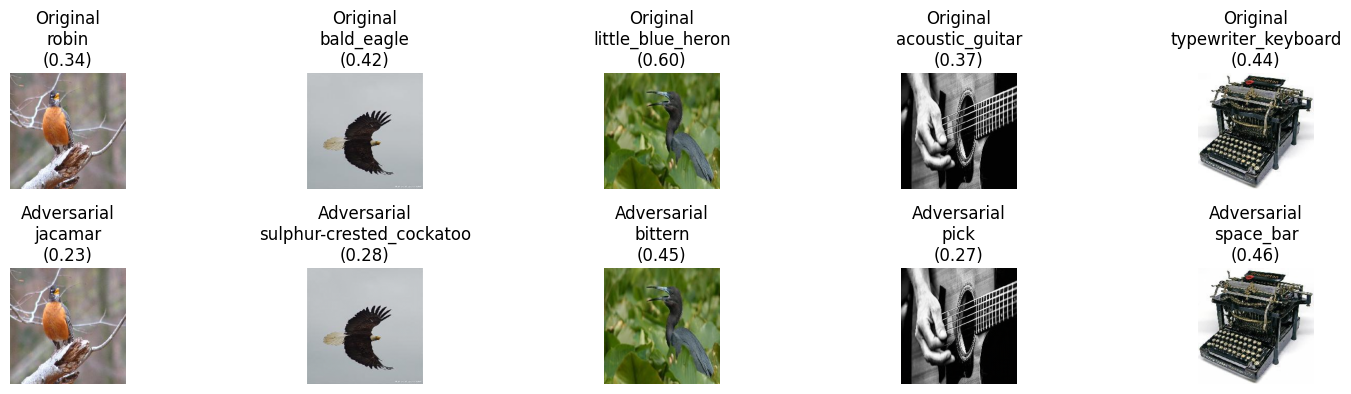

In [ ]:
vis_compare_images(val_x, adv_val_x)

## Autoencoder Defense

An Autoencoder (AE) is a type of neural network used for unsupervised learning, primarily for dimensionality reduction or feature learning. It consists of two main parts:

1.  **Encoder:** Compresses the input data into a lower-dimensional latent representation (the "code" or "bottleneck").
2.  **Decoder:** Reconstructs the original input data from the latent representation.

**How it works for defense:**
The key idea is to train the autoencoder to reconstruct *clean* images well, while potentially *filtering out* the small, high-frequency perturbations added by adversarial attacks. We train the AE using clean images as both input and target, or sometimes using noisy/adversarial images as input and their clean counterparts as the target.

When an adversarial image is fed into the trained AE, the encoder compresses it, potentially discarding some of the adversarial noise structure. The decoder then attempts to reconstruct the *original*, clean image structure it learned during training.

**Process:**
`Adversarial Image` -> `Trained Autoencoder` -> `Reconstructed (Denoised) Image` -> `Classifier`

The final classification is performed on the reconstructed image.

In [ ]:
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    """Defines a Convolutional Layer block with LeakyReLU, Dropout, BatchNormalization."""
    prefix = f'block_{block_id}_'
    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    """Defines a Transpose Convolutional Layer block."""
    prefix = f'block_{block_id}_'
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

# Autoencoder Model Definition
def AutoEncdoer(input_shape):
    """Defines the Autoencoder model architecture."""
    inputs = layers.Input(shape=input_shape)
    # Encoder part
    conv1 = Conv2DLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 64, 3, strides=2, padding='same', block_id=2)
    conv3 = Conv2DLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)
    conv4 = Conv2DLayer(conv3, 128, 3, strides=1, padding='same', block_id=4)
    conv5 = Conv2DLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    conv6 = Conv2DLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    conv7 = Conv2DLayer(conv6, 1024, 3, strides=2, padding='same', block_id=60) # Bottleneck

    # Decoder part with skip connections
    deconv0 = Transpose_Conv2D(conv7, 1024, 3, strides=2, padding='same', block_id=7)
    skip0 = layers.concatenate([deconv0, conv6], name='skip0')
    conv77 = Conv2DLayer(skip0, 512, 3, strides=1, padding='same', block_id=80)
    deconv1 = Transpose_Conv2D(conv77, 256, 3, strides=2, padding='same', block_id=90)
    skip1 = layers.concatenate([deconv1, conv5], name='skip1')
    conv7_2 = Conv2DLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    deconv2 = Transpose_Conv2D(conv7_2, 128, 3, strides=2, padding='same', block_id=9)
    skip2 = layers.concatenate([deconv2, conv3], name='skip2')
    conv8 = Conv2DLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    deconv3 = Transpose_Conv2D(conv8, 64, 3, strides=2, padding='same', block_id=11)
    skip3 = layers.concatenate([deconv3, conv2], name='skip3')
    conv9 = Conv2DLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    deconv4 = Transpose_Conv2D(conv9, 64, 3, strides=2, padding='same', block_id=13)
    skip4 = layers.concatenate([deconv4, conv1], name='skip4')
    # Final layer to reconstruct the image
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid', kernel_initializer=orthogonal(), name='final_conv')(skip4)
    return models.Model(inputs=inputs, outputs=conv10)



In [ ]:
input_shape_ae = (224, 224, 3)
autoencoder_model = AutoEncdoer(input_shape_ae)

model_opt = Adam(learning_rate=0.002)
autoencoder_model.compile(optimizer=model_opt, loss='mse', metrics=['accuracy'])

autoencoder_model.summary() # Print model summary

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_conv        │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_lrelu       │ (None, 224, 224,  │          0 │ block_1_conv[0][… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_drop        │ (None, 224, 224,  │          0 │ block_1_lrelu[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_conv_bn     │ (None, 224, 224,  │        256 │ block_1_drop[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_conv        │ (None, 112, 112,  │     36,928 │ block_1_conv_bn[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_lrelu       │ (None, 112, 112,  │          0 │ block_2_conv[0][… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_drop        │ (None, 112, 112,  │          0 │ block_2_lrelu[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_conv_bn     │ (None, 112, 112,  │        256 │ block_2_drop[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3_conv        │ (None, 56, 56,    │    204,928 │ block_2_conv_bn[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3_lrelu       │ (None, 56, 56,    │          0 │ block_3_conv[0][… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3_drop        │ (None, 56, 56,    │          0 │ block_3_lrelu[0]… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3_conv_bn     │ (None, 56, 56,    │        512 │ block_3_drop[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4_conv        │ (None, 56, 56,    │    147,584 │ block_3_conv_bn[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4_lrelu       │ (None, 56, 56,    │          0 │ block_4_conv[0][… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4_drop        │ (None, 56, 56,    │          0 │ block_4_lrelu[0]… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4_conv_bn     │ (None, 56, 56,    │        512 │ block_4_drop[0][

 Total params: 27,438,979 (104.67 MB)

 Trainable params: 27,429,635 (104.64 MB)

 Non-trainable params: 9,344 (36.50 KB)

In [ ]:
# Load Autoencoder Weights
autoencoder_model.load_weights(weights_path)

# Defend: Reconstruct Adversarial Images
reconstructed_val_x = autoencoder_model.predict(adv_val_x)
print("Reconstruction complete.")
print("Reconstructed set shape:", reconstructed_val_x.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Reconstruction complete.
Reconstructed set shape: (20, 224, 224, 3)


## 12. Visualize Results
Compare the Original images, the Adversarial images generated by FGSM, and the images Reconstructed by the Autoencoder. Observe how the autoencoder attempts to clean the adversarial perturbations, and sometimes too smoothing the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


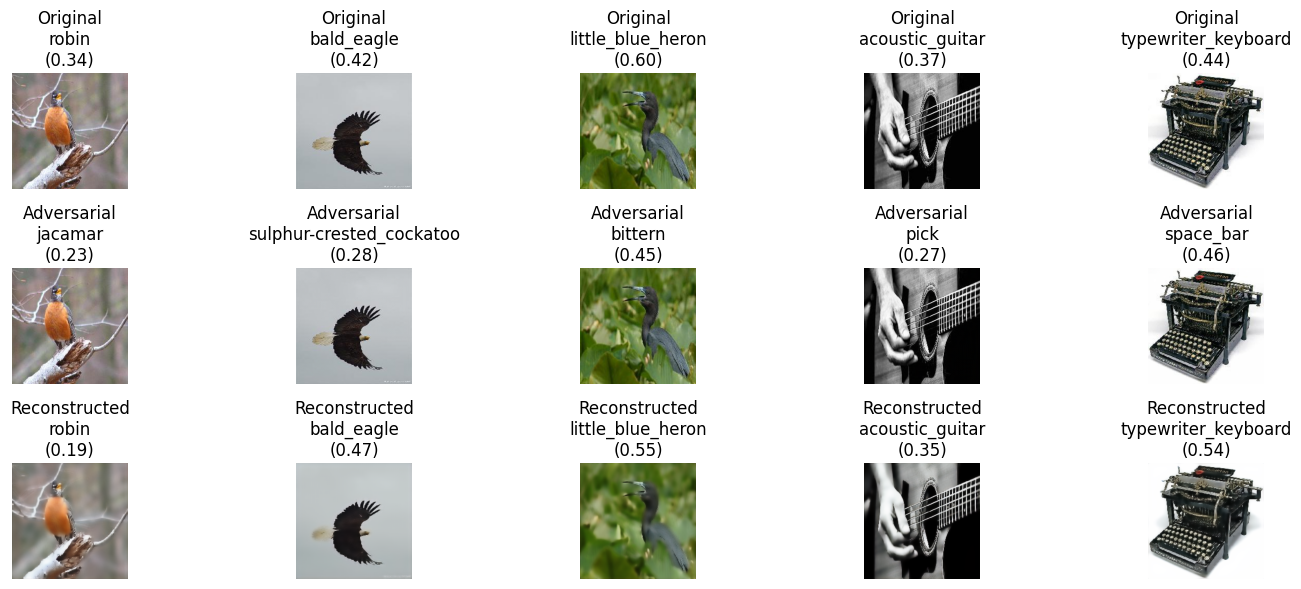

In [ ]:
vis_compare_images(val_x, adv_val_x, reconstructed_val_x)